In [19]:
import datetime
from sklearn import metrics, model_selection, ensemble
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [ ]:
try: 
    import optuna
except:
    !pip install optuna
    import optuna

In [ ]:
try:
    from catboost import Pool, CatBoostRegressor, cv
except:
    !pip install catboost 
    from catboost import Pool, CatBoostRegressor, cv

In [ ]:
try:
    from CustomPipeline import *
except:
    import sys
    sys.path.insert(0,'/content/sample_data')
    from CustomPipeline import *
    print("ok")

In [20]:
# test = pd.read_csv("./test.csv", delimiter=",", sep='.')
# train = pd.read_csv("./train.csv", delimiter=",", sep='.')

# test = pd.read_csv("./test_anomaly.csv", delimiter=",", sep='.')
# train = pd.read_csv("./train_anomaly.csv", delimiter=",", sep='.')

try:
    train = pd.read_csv("./train_anomaly.csv", delimiter=",", sep='.')
except:
    train = pd.read_csv("./sample_data/train_anomaly.csv", delimiter=",", sep='.')

In [21]:
pd.set_option('display.max_columns', None)
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target,anomaly_col,cont1_clusters
0,1,B,B,B,C,B,B,A,E,C,N,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634,Norm,cluster_low
1,2,B,B,A,A,B,D,A,F,A,O,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233,Anomaly,cluster_low
2,3,A,A,A,C,B,D,A,D,A,F,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351,Anomaly,cluster_low
3,4,B,B,A,C,B,D,A,E,C,K,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253,Norm,cluster_high
4,6,A,A,A,C,B,D,A,E,A,N,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260,Norm,cluster_low


In [ ]:
X = train.drop(["target", "id"], axis=1)
y = train["target"]

In [23]:
num_train = X.select_dtypes([int, float])
cat_train = X.select_dtypes(object)

num = list(num_train)
cat = list(cat_train)

idx = [X.columns.get_loc(i) for i in cat]

In [28]:
train_pool = Pool(X, y, cat_features=idx)

def objective(trial):

#     param = {
#         "iterations": 200, 
#         "loss_function": "RMSE",
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
#         "depth": trial.suggest_int("depth", 1, 12),
#         "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "bootstrap_type": trial.suggest_categorical(
#             "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
#         ),
#         "used_ram_limit": "3gb",
#     }

#     if param["bootstrap_type"] == "Bayesian":
#         param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#     elif param["bootstrap_type"] == "Bernoulli":
#         param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    param = {
        'iterations' : trial.suggest_int('iterations', 100, 500),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                                    
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
    }
    param["loss_function"] ="RMSE"
    
    rmse = cv(train_pool, param, fold_count=5, plot=False, logging_level="Silent")

    return rmse['test-RMSE-mean'].iloc[-1]

In [ ]:
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=20, n_jobs=-1)

[I 2021-08-20 19:11:00,419] A new study created in memory with name: no-name-11035aae-3115-43a8-aa50-6b9fa5496964


In [ ]:
best_params = study.best_trial.params
best_params

In [13]:
# train_xy, valid_xy = train_test_split(train, test_size=0.7, random_state=42)

# train_x = train_xy.drop(["target", "id"], axis=1)
# train_y = train_xy["target"]

# valid_x = valid_xy.drop(["target", "id"], axis=1)
# valid_y = valid_xy["target"]

In [14]:
# train_pool = Pool(train_x, 
#                   train_y, 
#                   cat_features=list(range(10)) + [24, 25])

# test_pool = Pool(valid_x, 
#                   cat_features=list(range(10)) + [24, 25])

# params = best_params.copy()
# params["loss_function"] ="RMSE"


# model = CatBoostRegressor(**params)
# #train the model
# model.fit(train_pool)
# # make the prediction using the resulting model
# pred = model.predict(test_pool)

0:	learn: 0.7375344	total: 95.3ms	remaining: 1m 9s
1:	learn: 0.7375325	total: 282ms	remaining: 1m 43s
2:	learn: 0.7375309	total: 496ms	remaining: 2m
3:	learn: 0.7375309	total: 515ms	remaining: 1m 33s
4:	learn: 0.7375309	total: 532ms	remaining: 1m 17s
5:	learn: 0.7375308	total: 692ms	remaining: 1m 23s
6:	learn: 0.7375307	total: 914ms	remaining: 1m 34s
7:	learn: 0.7375304	total: 1.06s	remaining: 1m 36s
8:	learn: 0.7375301	total: 1.14s	remaining: 1m 31s
9:	learn: 0.7375301	total: 1.15s	remaining: 1m 23s
10:	learn: 0.7375299	total: 1.3s	remaining: 1m 25s
11:	learn: 0.7375267	total: 1.44s	remaining: 1m 26s
12:	learn: 0.7375265	total: 1.49s	remaining: 1m 22s
13:	learn: 0.7375235	total: 1.62s	remaining: 1m 23s
14:	learn: 0.7375231	total: 1.81s	remaining: 1m 26s
15:	learn: 0.7375197	total: 1.91s	remaining: 1m 25s
16:	learn: 0.7375196	total: 1.99s	remaining: 1m 23s
17:	learn: 0.7375179	total: 2.13s	remaining: 1m 24s
18:	learn: 0.7375175	total: 2.38s	remaining: 1m 29s
19:	learn: 0.7375157	total:

163:	learn: 0.7373600	total: 17.1s	remaining: 59.4s
164:	learn: 0.7373582	total: 17.3s	remaining: 59.5s
165:	learn: 0.7373575	total: 17.6s	remaining: 1m
166:	learn: 0.7373569	total: 17.8s	remaining: 1m
167:	learn: 0.7373568	total: 17.9s	remaining: 1m
168:	learn: 0.7373544	total: 18.2s	remaining: 1m
169:	learn: 0.7373538	total: 18.3s	remaining: 1m
170:	learn: 0.7373534	total: 18.5s	remaining: 1m
171:	learn: 0.7373500	total: 18.7s	remaining: 1m
172:	learn: 0.7373500	total: 18.7s	remaining: 1m
173:	learn: 0.7373498	total: 18.9s	remaining: 1m
174:	learn: 0.7373498	total: 18.9s	remaining: 1m
175:	learn: 0.7373498	total: 19s	remaining: 1m
176:	learn: 0.7373477	total: 19.1s	remaining: 59.9s
177:	learn: 0.7373476	total: 19.2s	remaining: 59.9s
178:	learn: 0.7373472	total: 19.3s	remaining: 59.9s
179:	learn: 0.7373442	total: 19.5s	remaining: 59.8s
180:	learn: 0.7373435	total: 19.6s	remaining: 59.8s
181:	learn: 0.7373435	total: 19.7s	remaining: 59.7s
182:	learn: 0.7373435	total: 19.8s	remaining: 5

324:	learn: 0.7371817	total: 38.2s	remaining: 47.9s
325:	learn: 0.7371791	total: 38.4s	remaining: 47.9s
326:	learn: 0.7371785	total: 38.5s	remaining: 47.7s
327:	learn: 0.7371779	total: 38.6s	remaining: 47.7s
328:	learn: 0.7371776	total: 38.7s	remaining: 47.5s
329:	learn: 0.7371775	total: 38.9s	remaining: 47.5s
330:	learn: 0.7371775	total: 38.9s	remaining: 47.3s
331:	learn: 0.7371775	total: 38.9s	remaining: 47s
332:	learn: 0.7371773	total: 39.1s	remaining: 46.9s
333:	learn: 0.7371773	total: 39.1s	remaining: 46.7s
334:	learn: 0.7371772	total: 39.3s	remaining: 46.7s
335:	learn: 0.7371772	total: 39.4s	remaining: 46.6s
336:	learn: 0.7371754	total: 39.6s	remaining: 46.5s
337:	learn: 0.7371733	total: 39.7s	remaining: 46.4s
338:	learn: 0.7371733	total: 39.8s	remaining: 46.2s
339:	learn: 0.7371733	total: 39.9s	remaining: 46.1s
340:	learn: 0.7371724	total: 40s	remaining: 46s
341:	learn: 0.7371706	total: 40.2s	remaining: 45.9s
342:	learn: 0.7371681	total: 40.4s	remaining: 45.9s
343:	learn: 0.7371

484:	learn: 0.7370241	total: 57.6s	remaining: 29.4s
485:	learn: 0.7370240	total: 57.7s	remaining: 29.3s
486:	learn: 0.7370240	total: 57.8s	remaining: 29.2s
487:	learn: 0.7370220	total: 58s	remaining: 29.1s
488:	learn: 0.7370220	total: 58s	remaining: 28.9s
489:	learn: 0.7370201	total: 58.1s	remaining: 28.8s
490:	learn: 0.7370198	total: 58.3s	remaining: 28.7s
491:	learn: 0.7370196	total: 58.4s	remaining: 28.6s
492:	learn: 0.7370188	total: 58.5s	remaining: 28.5s
493:	learn: 0.7370188	total: 58.6s	remaining: 28.3s
494:	learn: 0.7370185	total: 58.7s	remaining: 28.2s
495:	learn: 0.7370166	total: 58.8s	remaining: 28.1s
496:	learn: 0.7370138	total: 58.9s	remaining: 28s
497:	learn: 0.7370121	total: 59s	remaining: 27.8s
498:	learn: 0.7370087	total: 59.1s	remaining: 27.7s
499:	learn: 0.7370087	total: 59.1s	remaining: 27.5s
500:	learn: 0.7370084	total: 59.3s	remaining: 27.5s
501:	learn: 0.7370082	total: 59.4s	remaining: 27.4s
502:	learn: 0.7370062	total: 59.6s	remaining: 27.3s
503:	learn: 0.737005

643:	learn: 0.7368751	total: 1m 14s	remaining: 10.3s
644:	learn: 0.7368750	total: 1m 14s	remaining: 10.2s
645:	learn: 0.7368750	total: 1m 14s	remaining: 10.1s
646:	learn: 0.7368745	total: 1m 14s	remaining: 9.95s
647:	learn: 0.7368731	total: 1m 14s	remaining: 9.83s
648:	learn: 0.7368731	total: 1m 14s	remaining: 9.7s
649:	learn: 0.7368712	total: 1m 15s	remaining: 9.59s
650:	learn: 0.7368712	total: 1m 15s	remaining: 9.46s
651:	learn: 0.7368702	total: 1m 15s	remaining: 9.36s
652:	learn: 0.7368692	total: 1m 15s	remaining: 9.26s
653:	learn: 0.7368654	total: 1m 15s	remaining: 9.15s
654:	learn: 0.7368653	total: 1m 15s	remaining: 9.03s
655:	learn: 0.7368653	total: 1m 15s	remaining: 8.91s
656:	learn: 0.7368647	total: 1m 16s	remaining: 8.79s
657:	learn: 0.7368647	total: 1m 16s	remaining: 8.67s
658:	learn: 0.7368647	total: 1m 16s	remaining: 8.55s
659:	learn: 0.7368633	total: 1m 16s	remaining: 8.43s
660:	learn: 0.7368633	total: 1m 16s	remaining: 8.31s
661:	learn: 0.7368602	total: 1m 16s	remaining: 

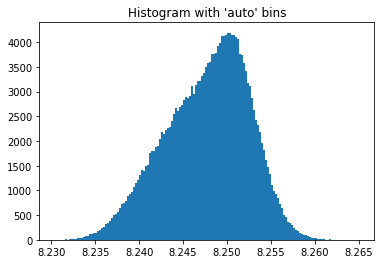

In [15]:
# import matplotlib.pyplot as plt

# plt.hist(pred, bins='auto')  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
# plt.show()

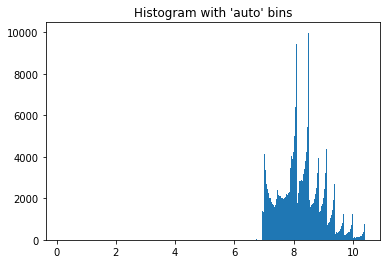

In [16]:
# import matplotlib.pyplot as plt

# plt.hist(valid_y, bins='auto')  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
# plt.show()

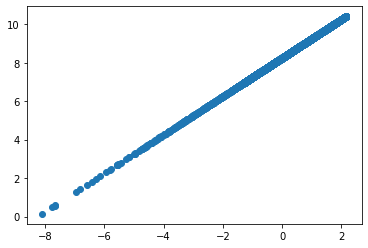

In [17]:
# import matplotlib.pyplot as plt


# residuals = valid_y - pred 
# plt.scatter(residuals, valid_y)

# plt.show()

In [18]:
# mean_squared_error(valid_y, pred, squared=False)

0.7455823858553343

In [125]:
# test_pool = Pool(test.drop(["id"], axis=1), 
#                  cat_features=list(range(10)) + [24, 25])

# model = CatBoostRegressor(**params)
# model.fit(train_pool)
# preds = model.predict(test_pool)

0:	learn: 74.6976411	total: 110ms	remaining: 38.8s
1:	learn: 74.6150543	total: 227ms	remaining: 39.9s
2:	learn: 74.5952946	total: 320ms	remaining: 37.3s
3:	learn: 74.5210058	total: 432ms	remaining: 37.7s
4:	learn: 74.4883525	total: 530ms	remaining: 36.9s
5:	learn: 74.4883525	total: 552ms	remaining: 31.9s
6:	learn: 74.4880257	total: 600ms	remaining: 29.6s
7:	learn: 74.4266535	total: 701ms	remaining: 30.2s
8:	learn: 74.4234383	total: 774ms	remaining: 29.6s
9:	learn: 74.4211215	total: 847ms	remaining: 29.1s
10:	learn: 74.3477036	total: 952ms	remaining: 29.6s
11:	learn: 74.3476750	total: 1.01s	remaining: 28.7s
12:	learn: 74.3453445	total: 1.08s	remaining: 28.4s
13:	learn: 74.3124045	total: 1.18s	remaining: 28.5s
14:	learn: 74.2603282	total: 1.3s	remaining: 29.4s
15:	learn: 74.2374271	total: 1.43s	remaining: 30.1s
16:	learn: 74.2093457	total: 1.5s	remaining: 29.7s
17:	learn: 74.1966004	total: 1.55s	remaining: 28.8s
18:	learn: 74.1886552	total: 1.59s	remaining: 28s
19:	learn: 74.1886552	tota

159:	learn: 71.2379167	total: 18.7s	remaining: 22.6s
160:	learn: 71.2373295	total: 18.8s	remaining: 22.4s
161:	learn: 71.2261924	total: 18.9s	remaining: 22.3s
162:	learn: 71.2187172	total: 19s	remaining: 22.2s
163:	learn: 71.2151842	total: 19.1s	remaining: 22.1s
164:	learn: 71.2017961	total: 19.3s	remaining: 22s
165:	learn: 71.2002498	total: 19.4s	remaining: 21.8s
166:	learn: 71.1877303	total: 19.5s	remaining: 21.7s
167:	learn: 71.1790233	total: 19.6s	remaining: 21.6s
168:	learn: 71.1786597	total: 19.7s	remaining: 21.5s
169:	learn: 71.1700899	total: 19.8s	remaining: 21.3s
170:	learn: 71.1570415	total: 19.9s	remaining: 21.2s
171:	learn: 71.1520203	total: 20.1s	remaining: 21.1s
172:	learn: 71.1389925	total: 20.2s	remaining: 21s
173:	learn: 71.1284982	total: 20.3s	remaining: 20.9s
174:	learn: 71.1179139	total: 20.4s	remaining: 20.8s
175:	learn: 71.0996738	total: 20.5s	remaining: 20.7s
176:	learn: 71.0918765	total: 20.7s	remaining: 20.5s
177:	learn: 71.0851104	total: 20.8s	remaining: 20.4s

315:	learn: 70.0441252	total: 38.2s	remaining: 4.47s
316:	learn: 70.0340535	total: 38.3s	remaining: 4.35s
317:	learn: 70.0267214	total: 38.4s	remaining: 4.23s
318:	learn: 70.0151630	total: 38.5s	remaining: 4.11s
319:	learn: 70.0045296	total: 38.6s	remaining: 3.98s
320:	learn: 70.0035240	total: 38.7s	remaining: 3.86s
321:	learn: 69.9944140	total: 38.9s	remaining: 3.74s
322:	learn: 69.9847081	total: 39s	remaining: 3.62s
323:	learn: 69.9824652	total: 39.1s	remaining: 3.5s
324:	learn: 69.9714489	total: 39.2s	remaining: 3.38s
325:	learn: 69.9595263	total: 39.3s	remaining: 3.26s
326:	learn: 69.9487069	total: 39.5s	remaining: 3.14s
327:	learn: 69.9399083	total: 39.6s	remaining: 3.02s
328:	learn: 69.9297652	total: 39.7s	remaining: 2.9s
329:	learn: 69.9208932	total: 39.8s	remaining: 2.78s
330:	learn: 69.9107761	total: 40s	remaining: 2.66s
331:	learn: 69.9052863	total: 40.1s	remaining: 2.54s
332:	learn: 69.8967557	total: 40.2s	remaining: 2.42s
333:	learn: 69.8879141	total: 40.3s	remaining: 2.29s

In [126]:
# test['target'] = preds/100

In [127]:
# test.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,anomaly_col,target
0,0,B,B,B,C,B,B,A,E,E,I,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702,0,7.989977
1,5,A,B,A,C,B,C,A,E,C,H,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940,0,8.468202
2,15,B,A,A,A,B,B,A,E,D,K,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099,0,8.425447
3,16,B,B,A,C,B,D,A,E,A,N,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372,0,8.275489
4,17,B,B,A,C,B,C,A,E,C,F,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412,0,8.141189


In [128]:
# test[['id', 'target']].to_csv('catboost_anomaly.csv', index=False)